# SODUKO PROJECT
**Mohammad Amir Saraee**

student number: 400412292

## Phase3

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt

###  CNN مدل

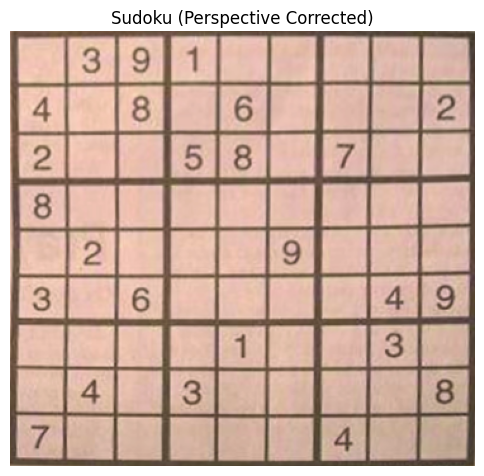


Sudoku Grid Detected:
9  3  8  7  7  7  7  7  7
8  7  8  7  5  7  7  8  8
8  7  7  7  8  7  7  7  7
7  7  7  7  7  7  7  7  7
7  8  7  7  7  9  7  7  7
8  8  5  7  7  7  7  8  8
8  8  7  7  8  8  7  8  2
6  8  8  8  8  2  2  8  8
2  2  2  0  2  0  8  2  6


In [ ]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitCNN().to(device)
model.load_state_dict(torch.load("digit_cnn.pth", map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def order_points(pts):
    pts = pts.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def get_warped_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            rect = order_points(approx)
            break
    else:
        raise Exception("Sudoku contour not found!")

    (tl, tr, br, bl) = rect
    width = max(int(np.linalg.norm(br - bl)), int(np.linalg.norm(tr - tl)))
    height = max(int(np.linalg.norm(tr - br)), int(np.linalg.norm(tl - bl)))
    dst = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped

def extract_cells(grid_img):
    cells = []
    height, width = grid_img.shape[:2]
    cell_h = height // 9
    cell_w = width // 9
    for i in range(9):
        row = []
        for j in range(9):
            x, y = j * cell_w, i * cell_h
            cell = grid_img[y:y+cell_h, x:x+cell_w]
            row.append(cell)
        cells.append(row)
    return cells

def prepare_cell(cell_img):
    gray = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    c = max(contours, key=cv2.contourArea)
    if cv2.contourArea(c) < 50:
        return None
    x, y, w, h = cv2.boundingRect(c)
    digit = thresh[y:y+h, x:x+w]
    resized = cv2.resize(digit, (18, 18))
    padded = np.pad(resized, ((5, 5), (5, 5)), "constant", constant_values=0)
    tensor = transform(padded).unsqueeze(0).to(device)
    return tensor

def predict_digit(cell_img):
    input_tensor = prepare_cell(cell_img)
    if input_tensor is None:
        return 0
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        return pred.item()

def extract_sudoku_digits(image_path):
    image = cv2.imread(image_path)
    warped = get_warped_image(image)
    cells = extract_cells(warped)

    sudoku_grid = []
    for i in range(9):
        row = []
        for j in range(9):
            digit = predict_digit(cells[i][j])
            row.append(digit)
        sudoku_grid.append(row)

    return warped, sudoku_grid

# ---------------------- اجرا ----------------------
if __name__ == "__main__":
    
    path = r"C:\Users\masar\Desktop\University\ML\Sudoku_project\Phase_1\Pics\sample6.png"  # مسیر تصویر ورودی
    warped, grid = extract_sudoku_digits(path)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title("Sudoku (Perspective Corrected)")
    plt.axis('off')
    plt.show()
    print("\nSudoku Grid Detected:")
    for row in grid:
        print("  ".join(str(num) if num != 0 else "0" for num in row))


